1) Delete the label column
2) Separate X,y
3) Check for missing values
4) Impute missing values with KNN imputer
5) Get columns with zero standard deviation and remove them

In [1]:
import os
from pathlib import Path
os.chdir(Path("E:\FSDS_NOV\ML-WaferFault-Detection"))

In [21]:
import pandas as pd
import numpy as np
import pickle
from waferFaultDetection.constants import *
from waferFaultDetection.utils import read_yaml,create_directories
from waferFaultDetection import logger

In [22]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataPreprocessingConfig:
    '''
    Define the resources required for the data preprocessing
    such as dataset file name, label column name, null data summary, standard deviation summary etc.
    '''
    root_dir: Path
    model_input_file: Path
    sensor_name_column: str
    label_column_name: str
    null_summary_file: Path
    zero_stddev_columns_file: Path
    preprocessed_model_input_file: Path
    elbow_plot_file: Path
    kmeans_model_file: Path
    
# DataIngestionConfig = namedtuple("DataIngestionConfig",[
#     "root_dir",
#     "source_URL",
#     "local_data_file",
#     "unzip_dir"
# ])

In [23]:
from waferFaultDetection import logger
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH
        ):

        logger.info("reading yaml files for configs and parameters")
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        logger.info("creating directory for artifacts")
        create_directories([self.config.artifacts_root])
        logger.info("artifacts directory created")

    def get_data_preprocessing_config(self) -> DataPreprocessingConfig:
        config = self.config.data_preprocessing
        logger.info("creating data preprocessing root directory")
        create_directories([config.root_dir])

        logger.info('creating data preprocessing configuration')
        data_preprocessing_config = DataPreprocessingConfig(
            root_dir = config.root_dir,
            model_input_file = config.model_input_file,
            sensor_name_column = config.sensor_name_column,
            label_column_name = config.label_column_name,
            null_summary_file = config.null_summary_file,
            zero_stddev_columns_file = config.zero_stddev_columns_file,
            preprocessed_model_input_file = config.preprocessed_model_input_file,
            elbow_plot_file = config.elbow_plot_file,
            kmeans_model_file = config.kmeans_model_file
        )
        return data_preprocessing_config

In [28]:
import pandas as pd
import numpy as np
from waferFaultDetection import logger
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

class Preprocessor:
    """
        This class shall  be used to clean and transform the data before training.

        Written By: Najam Sheikh
        Version: 1.0
        Revisions: None

        """
    def __init__(
        self,
        config:DataPreprocessingConfig
    ):
        self.config = config

    def create_model_df(self):
        """
                Method Name: remove_columns
                Description: This method creates model dataframe and removes the unnecessary columns.
                Output: A pandas DataFrame after removing the specified columns.
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info('Entered (create_model_df) method')
        data = pd.read_csv(self.config.model_input_file)
        sensor_name_column = self.config.sensor_name_column # unnecessary columns to be removed
        logger.info(f"Removing the columns {sensor_name_column} from model input file")
        try:
            self.model_df = data.drop(labels=sensor_name_column,axis=1) # dropping the labels specified in the columns parameter
            logger.info(f"Requested columns are removed from given input dataframe successfully")
            # return self.model_df
        except Exception as e:
            logger.info(f"Exception occured in (create_model_df) method. Exception message:{str(e)}")
            logger.info("Columns removal unsuccessful")
            raise e

    def separate_label_features(self):
        """
                Method Name: separate_label_features
                Description: This method separates the features and label from a pandas dataframe.
                Output: Two pandas DataFrames containing Features and label separately.
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info(f"Entered (separate_label_features) method")
        logger.info(f"Separating features and label columns")
        data = self.model_df
        label_column_name = self.config.label_column_name
        try:
            self.X = data.drop(labels=label_column_name,axis=1)
            self.y = data[label_column_name]
            logger.info(f"Separated features(X) and labels(y) from model dataframe successfully")
            # return self.X,self.y
        except Exception as e:
            logger.info(f"Exception occured in (separate_label_features) method. Exception message:{str(e)}")
            logger.info("Features and label separation unsuccessful")
            raise e

    def check_missing_values(self):
        """
                Method Name: check_missing_values
                Description: This method checks for missing values in the model dataframe.
                Output: If missing values present True, else False. If True, writes the summary to a file
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (check_missing_values) method")
        data = self.X
        logger.info('Checking for missing values in the model features dataframe')
        self.null_present = False
        try:
            self.null_counts = data.isna().sum() # compute the number of null values in the dataframe
            for i in self.null_counts:
                if i>0:
                    self.null_present = True
                    break
            if self.null_present:
                df_null_values = pd.DataFrame()
                df_null_values['columns'] = data.columns
                df_null_values['null_summary'] = np.asarray(data.isna().sum())
                df_null_values.to_csv(self.config.null_summary_file,index=False)
            logger.info("Finding missing values successful")
            logger.info(f"Written missing value columns to:{self.config.null_summary_file}")
            # return self.null_present
        except Exception as e:
            logger.info(f"Exception occured in (check_missing_values) method. Exception message:{str(e)}")
            logger.info("checking missing values unsuccessful")
            raise e

    def impute_missing_values(self):
        """
                Method Name: impute_missing_values
                Description: This method imputes missing values in the model dataframe using KNN imputer.
                Output: Pandas dataframe with all missing values imputed
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (impute_missing_values) method")
        data = self.X
        logger.info('imputing missing values with KNN imputer started')
        try:
            imputer = KNNImputer(n_neighbors=3,weights='uniform',missing_values=np.nan)
            new_array = imputer.fit_transform(data) # impute the missing values, output is numpy array
            self.X = pd.DataFrame(data = new_array,columns=data.columns)
            logger.info('Imputing missing values successful')
            # return self.X
        except Exception as e:
            logger.info(f"Exception occured in (check_missing_values) method. Exception message:{str(e)}")
            logger.info("checking missing values unsuccessful")
            raise e

    def drop_columns_with_zero_std_dev(self):
        """
                Method Name: get_columns_with_zero_std_dev
                Description: This method finds columns with constant values in the model dataframe.
                Output: Pandas dataframe removing constant value columns (zero std dev columns)
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (get_columns_with_zero_std_dev) method")
        data = self.X
        logger.info('Finding columns with zero standard deviation started')
        try:
            stats = data.describe() # gives a dataframe with stats as index
            zero_std_dev_cols = []
            for col in stats:
                if stats[col]['std'] == 0:
                    zero_std_dev_cols.append(col)
            zero_std_dev_cols_df = data[zero_std_dev_cols]
            zero_std_dev_cols_df.to_csv(self.config.zero_stddev_columns_file,index=False)
            self.X = data.drop(labels=zero_std_dev_cols,axis=1)
            logger.info('Finding zero std dev columns and dropping them successful')
            # return self.X
        except Exception as e:
            logger.info(f"Exception occured in (get_columns_with_zero_std_dev) method. Exception message:{str(e)}")
            logger.info("checking missing values unsuccessful")
            raise e

    def clusters_elbow_plot(self):
        """
                Method Name: elbow_plot
                Description: This method creates an elbow plot using kmeans clustering.
                Output: Returns number of clusters required
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (clusters_elbow_plot) method")
        X = self.X
        logger.info('Finding number of clusters using kmeans++ started')
        wcss = [] # Initialize within cluster sum of squares
        try:
            for i in range(1,11):
                kmeans = KMeans(n_clusters=i,n_init=10, init='k-means++',random_state=42) # initialized KMeans object
                kmeans.fit(X) # fitting the data to the KMeans Algorithm
                wcss.append(kmeans.inertia_)
            plt.plot(range(1,11),wcss) #graph between number of clusters and wcss
            plt.title("The Elbow Method")
            plt.xlabel("Number of clusters")
            plt.ylabel("WCSS")
            plt.savefig(self.config.elbow_plot_file)
            plt.show()
            #
            # Finding optimum cluster size
            #
            self.kn = KneeLocator(range(1,11),wcss,curve='convex',direction='decreasing')
            logger.info(f"The optimum number of clusters is {self.kn.knee}")
            self.no_optimum_clusters = self.kn.knee
            # return self.no_optimum_clusters
        except Exception as e:
            logger.info(f"Exception occured in (clusters_elbow_plot) method. Exception message:{str(e)}")
            logger.info("Concatenation of preprocessed X and y unsuccessful")
            raise e

    def create_clusters(self):
        """
                Method Name: create_clusters
                Description: This method creates a new dataframe with the number of clusters given
                Output: Returns a dataframe
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (create_clusters) method")
        logger.info('Creation of clusters started')

        X = self.X
        num_clusters = self.no_optimum_clusters
        try:
            kmeans = KMeans(n_clusters=num_clusters,n_init=10, init='k-means++',random_state=42) # initialized KMeans object
            y_kmeans = kmeans.fit_predict(X) # divide data into clusters
            with open(self.config.kmeans_model_file,'wb') as f:
                pickle.dump(kmeans,f)
            X['Cluster'] = y_kmeans # Creating a column 'Cluster' for storing cluster information
            self.X = X
            # return self.data
        except Exception as e:
            logger.info(f"Exception occured in (create_clusters) method. Exception message:{str(e)}")
            logger.info("Clusters creation unsuccessful")
            raise e

    def get_preprocessed_model_input_file(self):
        """
                Method Name: get_preprocessed_model_input_file
                Description: This method combines the modfied X with label column y.
                Output: Pandas dataframe combining X and y and writing to a csv file
                On Failure: Raise Exception

                Written By: Najam Sheikh
                Version: 1.0
                Revisions: None

        """
        logger.info("Entered (get_preprocessed_model_input_file) method")
        X = self.X
        y = self.y
        logger.info('Concatenation of preprocessed X and y started')
        try:
            df_X_y = pd.concat(objs=[X,y],axis=1)
            df_X_y.to_csv(self.config.preprocessed_model_input_file,index=False)
            logger.info('Concatenation of preprocessed X and y successful')
            # return self.X
        except Exception as e:
            logger.info(f"Exception occured in (get_preprocessed_model_input_file) method. Exception message:{str(e)}")
            logger.info("Concatenation of preprocessed X and y unsuccessful")
            raise e



[2023-02-09 22:48:51,183: INFO: 1523862481]: reading yaml files for configs and parameters
[2023-02-09 22:48:51,189: INFO: common]: yaml file: configs\config.yaml loaded successfully
[2023-02-09 22:48:51,193: INFO: common]: yaml file: params.yaml loaded successfully
[2023-02-09 22:48:51,195: INFO: 1523862481]: creating directory for artifacts
[2023-02-09 22:48:51,199: INFO: common]: created directory at: artifacts
[2023-02-09 22:48:51,201: INFO: 1523862481]: artifacts directory created
[2023-02-09 22:48:51,202: INFO: 1523862481]: creating data preprocessing root directory
[2023-02-09 22:48:51,204: INFO: common]: created directory at: artifacts/data_preprocessing
[2023-02-09 22:48:51,206: INFO: 1523862481]: creating data preprocessing configuration
[2023-02-09 22:48:51,207: INFO: 654853970]: Entered (create_model_df) method
[2023-02-09 22:48:51,356: INFO: 654853970]: Removing the columns Wafer from model input file
[2023-02-09 22:48:51,359: INFO: 654853970]: Requested columns are remove

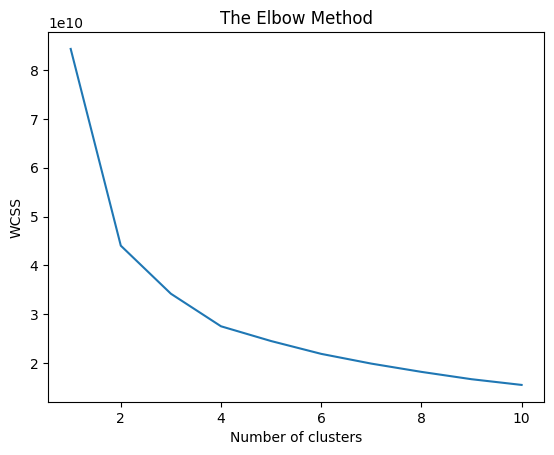

[2023-02-09 22:48:56,921: INFO: 654853970]: The optimum number of clusters is 3
[2023-02-09 22:48:56,922: INFO: 654853970]: Entered (create_clusters) method
[2023-02-09 22:48:56,924: INFO: 654853970]: Creation of clusters started
[2023-02-09 22:48:57,063: INFO: 654853970]: Entered (get_preprocessed_model_input_file) method
[2023-02-09 22:48:57,065: INFO: 654853970]: Concatenation of preprocessed X and y started
[2023-02-09 22:48:57,446: INFO: 654853970]: Concatenation of preprocessed X and y successful


In [29]:
try:
    config = ConfigurationManager()
    data_preprocessing_config = config.get_data_preprocessing_config()
    data_preprocessing = Preprocessor(config=data_preprocessing_config)
    data_preprocessing.create_model_df()
    data_preprocessing.separate_label_features()
    data_preprocessing.check_missing_values()
    data_preprocessing.impute_missing_values()
    data_preprocessing.drop_columns_with_zero_std_dev()
    data_preprocessing.clusters_elbow_plot()
    data_preprocessing.create_clusters()
    data_preprocessing.get_preprocessed_model_input_file()
except Exception as e:
    raise e